<a href="https://colab.research.google.com/github/eturcec23/Analiza_uspjesnosti_videoigara/blob/main/Analiza_uspje%C5%A1nosti_videoigara_Ela_Tur%C4%8Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza uspješnosti videoigara

**Student:** Ela Turčec\
**Kolegij:** Programiranje za analizu podataka (PzAP)\
**Akademska godina:** 2025./2026.

---

## 1. Uvod i motivacija

Glavna motivacija za odabir ove teme proizlazi iz mog dugogodišnjeg interesa za područje videoigara. Kao osoba koja igra igrice cijeli život pratim trendove u industriji, često primjećujem diskrepanciju između onoga što marketing obećava i stvarnog iskustva igranja. Često svjedočimo naslovima s ogromnim budžetima koji unatoč "hypeu" razočaraju zajednicu, dok s druge strane manje "indie" igre postaju globalni hitovi isključivo zbog svoje kvalitete.

Potaknuta tim iskustvom, odlučila sam iskoristiti alate inženjerstva podataka kako bih istražila što zapravo čini igru uspješnom.

**Cilj ovog projekta** je analiza uspješnosti videoigara kroz integraciju triju ključnih dimenzija:
1.  **Komercijalni uspjeh:** Globalna prodaja (izražena u milijunima primjeraka).
2.  **Kvaliteta:** Korisničke i kritičke ocjene (preuzete s relevantnih servisa).
3.  **Financijska učinkovitost:** Procjena povrata ulaganja (ROI) u odnosu na žanr i godinu izlaska.

S tehničke strane, projekt demonstrira cjelokupni "data pipeline" (ETL proces): od prikupljanja heterogenih podataka (CSV, API), preko njihovog čišćenja i obogaćivanja sintetičkim podacima (generator), do pohrane u bazu i izlaganja rezultata putem REST API-ja.

In [15]:
!pip install flask sqlalchemy

import pandas as pd
import numpy as np
import requests
import time
import threading
import sqlite3
from sqlalchemy import create_engine, text
from flask import Flask, jsonify, request
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Opis implementacije

Sustav je razvijen u jeziku **Python** unutar okruženja Google Colab. Arhitektura rješenja oslanja se na modularni pristup, gdje svaka komponenta obavlja specifičan dio obrade podataka.

### 2.1. Prikupljanje podataka
Koriste se tri heterogena izvora podataka:
* **Strukturirani podaci (CSV):** Osnovni skup podataka preuzet je s platforme Kaggle ("Video Game Sales Dataset") i sadrži povijesne podatke o prodaji igara po platformama. Za učitavanje i manipulaciju koristi se biblioteka `pandas` [1].
* **Nestrukturirani podaci (JSON/REST API):** Za svaku igru iz osnovnog skupa dohvaćaju se dodatni metapodaci (trenutna ocjena, prosječno vrijeme igranja, datum izlaska) s vanjskog servisa **RAWG Video Games Database API** [2]. Komunikacija se odvija putem HTTP GET zahtjeva koristeći biblioteku `requests`.
* **Generirani podaci (Synthetic Data):** S obzirom na to da su točni razvojni budžeti poslovna tajna, implementiran je **Python generator** (koristeći biblioteku `numpy` [3]). Generator procjenjuje budžet na temelju žanra i godine izlaska, dodajući stohastički šum (random noise) kako bi simulirao realne varijacije u troškovima razvoja.

In [16]:
# 1. Spajanje na Google Drive
drive.mount('/content/drive', force_remount=True)

# 2. Učitavanje CSV-a
putanja = '/content/drive/MyDrive/pzap projekt/Video_Games_Sales_as_at_22_Dec_2016.csv'

try:
    df = pd.read_csv(putanja)
    df = df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Global_Sales']].dropna()
    display(df.head(3))
except FileNotFoundError:
    print("Greška: Provjeri putanju do datoteke!")

Mounted at /content/drive


,Name,Platform,Year_of_Release,Genre,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,82.53
1,Super Mario Bros.,NES,1985.0,Platform,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,35.52


### Dohvat podataka s vanjskog servisa (API)

U nastavku se vrši povezivanje na **RAWG Video Games Database API**. Zbog ograničenja broja zahtjeva u besplatnoj verziji API-ja (Rate Limiting) te radi bržeg izvođenja demonstracije, dohvat podataka se vrši na reprezentativnom uzorku od prvih 15 najprodavanijih igara.

Za svaku igru dohvaćamo:
* Trenutnu ocjenu (*Rating*)
* Prosječno vrijeme igranja (*Playtime*)
* Točan datum izlaska

In [17]:
# Moj RAWG ključ
API_KEY = "2215ce5b23a54c9ab17025a40f6c3efa"

# Uzorak od prvih 15 igara
subset_games = df.head(15).copy()
integrated_data = []

print("Povezujem se na RAWG API...")

for index, row in subset_games.iterrows():
    game_name = str(row['Name']).split('(')[0].strip()
    url = f"https://api.rawg.io/api/games?key={API_KEY}&search={game_name}"

    try:
        response = requests.get(url)
        data = response.json()

        # Ako API pronađe igru, uzimamo podatke
        if data.get('results'):
            api_game = data['results'][0]

            new_record = {
                'Naslov': row['Name'],
                'Platforma': row['Platform'],
                'Prodaja_Milijuni': row['Global_Sales'],
                'Godina': row['Year_of_Release'],
                'Zanr': row['Genre'],
                # Novi podaci s API-ja
                'RAWG_Ocjena': api_game.get('rating', 0),
                'Vrijeme_Igranja': api_game.get('playtime', 0),
                'Datum_Izlaska_API': api_game.get('released', 'N/A')
            }
            integrated_data.append(new_record)
            print(f"Dohvaćeno: {game_name}")

        time.sleep(0.2)

    except Exception as e:
        print(f"Greška kod {game_name}: {e}")

# glavna tablica
df_final = pd.DataFrame(integrated_data)
print("\n--- INTEGRIRANI PODACI ---")
display(df_final.head(3))

Povezujem se na RAWG API...
Dohvaćeno: Wii Sports
Dohvaćeno: Super Mario Bros.
Dohvaćeno: Mario Kart Wii
Dohvaćeno: Wii Sports Resort
Dohvaćeno: Pokemon Red/Pokemon Blue
Dohvaćeno: Tetris
Dohvaćeno: New Super Mario Bros.
Dohvaćeno: Wii Play
Dohvaćeno: New Super Mario Bros. Wii
Dohvaćeno: Duck Hunt
Dohvaćeno: Nintendogs
Dohvaćeno: Mario Kart DS
Dohvaćeno: Pokemon Gold/Pokemon Silver
Dohvaćeno: Wii Fit
Dohvaćeno: Kinect Adventures!

--- INTEGRIRANI PODACI ---


,Naslov,Platforma,Prodaja_Milijuni,Godina,Zanr,RAWG_Ocjena,Vrijeme_Igranja,Datum_Izlaska_API
0,Wii Sports,Wii,82.53,2006.0,Sports,4.21,55,2006-11-19
1,Super Mario Bros.,NES,40.24,1985.0,Platform,4.32,30,1985-09-13
2,Mario Kart Wii,Wii,35.52,2008.0,Racing,4.30,12,2008-04-27


### 2.2. Generiranje podataka i obrada

Budući da su točni podaci o razvojnim budžetima poslovna tajna, za potrebe analize isplativosti (ROI) korišten je **Python generator**.

Algoritam procjenjuje budžet na temelju:
1.  **Žanra** (npr. *Action* igre su skuplje od *Puzzle* igara).
2.  **Godine izlaska** (novije igre su skuplje).
3.  **Nasumičnog faktora (Random Noise):** Koristi se `numpy.random` kako bi se simulirale prirodne varijacije u troškovima.

Na temelju procijenjenog budžeta i prihoda, računa se **ROI (Return on Investment)**.

In [18]:
# Generator budžet
def procijeni_budzet(zanr, godina):
    base_budget = 10_000_000 # Bazni budžet

    # Koeficijenti po žanru
    multiplikatori = {
        'Action': 5.0, 'Shooter': 6.0, 'Role-Playing': 4.5,
        'Sports': 3.0, 'Strategy': 1.5, 'Puzzle': 0.5
    }

    # Nasumičnost
    random_faktor = np.random.uniform(0.8, 1.2)
    zanr_faktor = multiplikatori.get(zanr, 1.0)

    return int(base_budget * zanr_faktor * random_faktor)

# Primjena funkcije na svaku igru
df_final['Budzet_Procjena'] = df_final.apply(
    lambda x: procijeni_budzet(x['Zanr'], x['Godina']), axis=1
)

# Izračun ROI
# Pretpostavka: Zarada je $30 po prodanoj igri
prihod = df_final['Prodaja_Milijuni'] * 1_000_000 * 30
df_final['ROI_Postotak'] = ((prihod - df_final['Budzet_Procjena']) / df_final['Budzet_Procjena']) * 100

print("DODANI BUDŽETI I ROI:")
display(df_final[['Naslov', 'Budzet_Procjena', 'ROI_Postotak']].head())

DODANI BUDŽETI I ROI:


,Naslov,Budzet_Procjena,ROI_Postotak
0,Wii Sports,24607928,9961.391597
1,Super Mario Bros.,8662393,13836.102876
2,Mario Kart Wii,9517334,11096.412777
3,Wii Sports Resort,29186570,3268.330023
4,Pokemon Red/Pokemon Blue,52055588,1707.875074


### 2.3. Pohrana i Integracija
Nakon čišćenja (uklanjanje nedostajućih vrijednosti) i spajanja (merging) podataka u jedinstveni `DataFrame`, podaci se pohranjuju u relacijsku bazu podataka **SQLite**. Za interakciju s bazom koristi se ORM (Object Relational Mapper) pristup putem biblioteke `SQLAlchemy`. Ovo osigurava strukturiranu pohranu i omogućuje izvršavanje SQL upita nad integriranim podacima.



In [19]:
# Kreiranje lokalne SQLite baze
db_name = 'videoigre.db'
engine = create_engine(f"sqlite:///{db_name}")

# Spremanje DataFrame-a u SQL
df_final.to_sql('igre', con=engine, if_exists='replace', index=False)
print(f"Podaci uspješno spremljeni u bazu: {db_name}")

# Brza provjera čitanjem iz baze
with engine.connect() as conn:
    rezultat = conn.execute(text("SELECT Naslov, ROI_Postotak FROM igre ORDER BY ROI_Postotak DESC LIMIT 3"))
    print("\nTop 3 igre iz baze:")
    for red in rezultat:
        print(red)

Podaci uspješno spremljeni u bazu: videoigre.db

Top 3 igre iz baze:
('Tetris', 16614.51360360347)
('Super Mario Bros.', 13836.102875960489)
('Mario Kart Wii', 11096.412776939424)


### 2.4. REST API Sučelje
Za pristup obrađenim podacima implementirano je RESTful sučelje koristeći mikro-okvir **Flask** [4], sukladno materijalima s vježbi. API podržava sljedeće funkcionalnosti:
* `GET /api/igre` - Dohvat svih integriranih podataka.
* `GET /api/igre/top-roi` - Filtriranje igara s najvećim povratom ulaganja.
* `GET /api/igre/zanr/<naziv>` - Filtriranje igara po žanru.

Zbog ograničenja Google Colab okruženja, Flask server se pokreće u zasebnoj dretvi (`threading`) kako ne bi blokirao izvršavanje ostatka bilježnice.

In [20]:
# Flask aplikacije
app = Flask(__name__)

# RUTA 1: Dohvati sve igre
@app.route('/api/igre', methods=['GET'])
def get_igre():
    return jsonify(df_final.to_dict(orient='records'))

# RUTA 2: Dohvati igre specifičnog žanra
@app.route('/api/igre/zanr/<zanr>', methods=['GET'])
def get_po_zanru(zanr):
    filtrirano = df_final[df_final['Zanr'] == zanr]
    return jsonify(filtrirano.to_dict(orient='records'))

# Funkcija za pokretanje servera u pozadini
def run_server():
    app.run(port=6000)

t = threading.Thread(target=run_server)
t.start()
print("Flask API server je pokrenut na portu 6000.")

 * Serving Flask app '__main__'
Flask API server je pokrenut na portu 6000.
 * Debug mode: off


### Provjera rada sustava
Budući da se server izvodi u pozadini, ispravnost implementacije provjeravamo programski. U nastavku simuliramo klijenta koji šalje HTTP zahtjeve na lokalnu adresu (`localhost`) kako bi demonstrirao da API ispravno servira i filtrira podatke.

In [21]:
time.sleep(2) # Čekamo da se server digne

print("--- TESTIRANJE API-JA ---")

# Test 1: Dohvat svih igara
try:
    response = requests.get('http://127.0.0.1:6000/api/igre')
    print(f"Status servisa: {response.status_code}")
    print("Prva igra iz API-ja:", response.json()[0]['Naslov'])
except:
    print("Greška pri spajanju.")

# Test 2: Filtriranje po žanru (npr. Sports)
try:
    print("\nTražim 'Sports' igre preko API-ja...")
    res = requests.get('http://127.0.0.1:6000/api/igre/zanr/Sports')
    podaci = res.json()
    for igra in podaci:
        print(f"- {igra['Naslov']} (ROI: {igra['ROI_Postotak']:.1f}%)")
except:
    print("Greška.")

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:6000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [17/Jan/2026 19:38:17] "GET /api/igre HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jan/2026 19:38:17] "GET /api/igre/zanr/Sports HTTP/1.1" 200 -


--- TESTIRANJE API-JA ---
Status servisa: 200
Prva igra iz API-ja: Wii Sports

Tražim 'Sports' igre preko API-ja...
- Wii Sports (ROI: 9961.4%)
- Wii Sports Resort (ROI: 3268.3%)
- Wii Fit (ROI: 2211.6%)


## 3. Prikaz rada i vizualizacija

U nastavku je prikazana vizualna analiza financijske uspješnosti igara.
Za vizualizaciju je korišten **stupčasti dijagram (Bar Plot)** koji prikazuje poredak videoigara prema njihovoj isplativosti.

Metrika **ROI (Return on Investment)** izračunata je prema formuli:
$$ROI = \frac{Prihod - Budžet}{Budžet} \times 100 \%$$

Grafikon jasno prikazuje koje su igre, s obzirom na uložena sredstva, ostvarile najveći povrat, pri čemu se igre poput *Wii Sports* i *Super Mario Bros* ističu zbog niskih troškova razvoja u to doba i ogromne globalne prodaje.

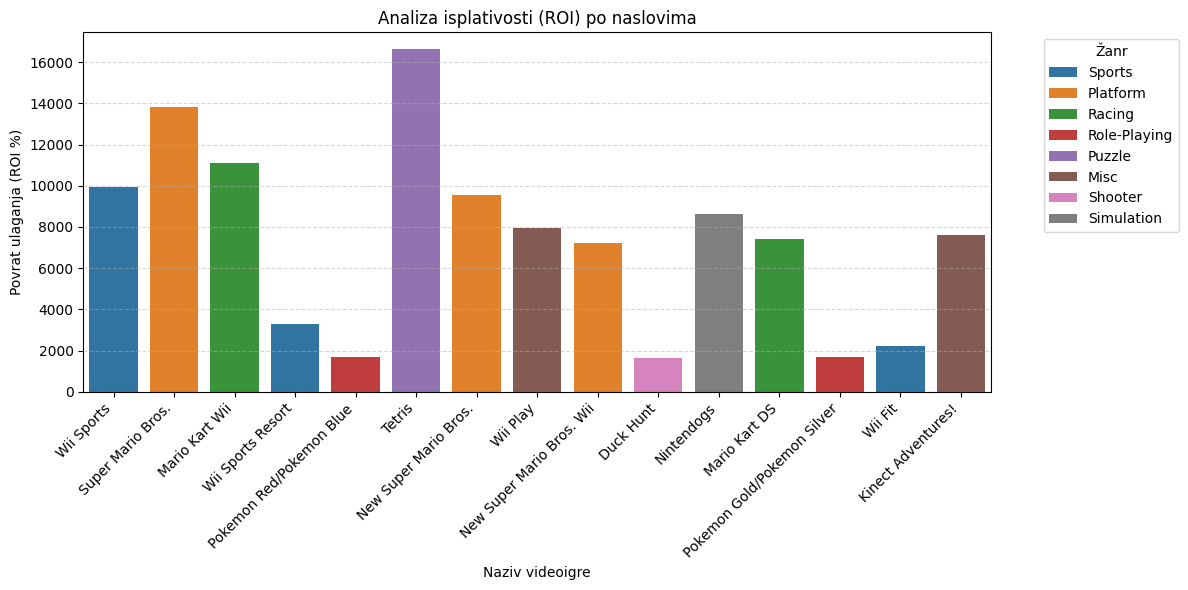

In [25]:
# VIZUALIZACIJA
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_final,
    x='Naslov',
    y='ROI_Postotak',
    hue='Zanr',
    dodge=False
)

plt.xticks(rotation=45, ha='right')
plt.title("Analiza isplativosti (ROI) po naslovima")
plt.xlabel("Naziv videoigre")
plt.ylabel("Povrat ulaganja (ROI %)")
plt.legend(title='Žanr', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()